# Model a decision tree classifier for tomatoes

This notebook demonstrates how to build a decision tree classifier. In order to build and test the classifier the following steps are performed. 

1. Data is generated based on literature data. 
2. Data is inspected to verify whether the generated data is according the literature
3. Data is visualized to gain more understanding about the data
4. Data is prepared for the model to train
5. Model is trained on the prepared data
6. Model is used to test the working of the model
7. Model is evaluated
8. Model is improved

In [10]:
#import general libraries
import random
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image
from subprocess import call

---

#  Data source

The following data is collected: 

- kind of tomato
- weight
- diamter
- kind of shape

The values per kind of tomato are derived from the publication of Gastélum Barrios, Abraham & Bórquez, Rafael & Rico-García, Enrique & Toledano-Ayala, Manuel & Soto-Zarazúa, Genaro. (2011). Tomato quality evaluation with image processing: A review. African Journal of Agricultural Research. 6. 

<table><tr>
  <td>
  <img src="images/Weight-form-and-diameter-of-tomato-fruits-of-different-types-Jaramillo-et-al-2007.png"  style="float:right"/> 
  </td>
  <td> 
  <img src="images/Forms-of-the-tomato-fruit-Source-Adapted-from-Jaramillo-et-al-2007.png" style="float:left"/> 
  </td>
</tr></table>
    



# Generate data 

For demonstration purpose we will generate samples from the summary table in the article. The data is generated data, which is artificial data generated with numpy

In [11]:
shapes = {1:'flattened', 2:'semi-flattened', 3:'round', 4:'puffed', 5:'flat', 
          6:'square', 7:'semi-oval', 8:'oval', 9:'cylindrical', 10:'pear', 11:'piriformis', 12:'heart-shaped'}

tomato = {1:'aurora', 2:'rebecca', 3:'sheila', 4:'reina', 5:'monalisa', 6:'debora plus', 7:'cherry'}

In [12]:
np.random.seed(42)

def generate_data(mu, sigma=0.2, k = 100):
    """function that generates random numbers according normal distribution"""
    return np.random.normal(mu, sigma, k)

def create_matrix(kind, low_weight, high_weight, diameter, shape_list, sample=100):
    X = np.zeros((sample, 4))
    X[:,0:1] = kind # tomato kind
    X[:,1:2] = np.reshape(np.random.randint(low = low_weight,high=high_weight,size=sample), (sample,1)) # weight
    X[:,2:3] = np.reshape((generate_data(diameter, k=sample)), (sample,1)) # diameter
    X[:,3:4] = np.reshape(random.choices(shape_list, k=sample), (sample,1)) # tomato shape
    return X

### Create per tomato kind a random set of data with a sample size of 100

In [13]:
sample = 1000
aurora = create_matrix(1, 220, 270, 7.6, [2,4], sample)
rebecca = create_matrix(2, 175, 185, 5.2, [3], sample)
sheila = create_matrix(3, 160,170, 5.6, [3], sample)
reina = create_matrix(4, 200,250, 8.7, [1,4], sample)
monalisa = create_matrix(5, 188,193, 6.4, [1,2], sample)
debora_plus = create_matrix(6, 130,140, 4.3, [3,8], sample)
cherry = create_matrix(7, 9,11, 2, [3,10], sample)

### Put all these matrices in one big matrix

In [14]:
to_concat = [pd.DataFrame(aurora), pd.DataFrame(rebecca),
             pd.DataFrame(sheila), pd.DataFrame(reina),
             pd.DataFrame(monalisa),pd.DataFrame(debora_plus), 
             pd.DataFrame(cherry)]
df = pd.concat(to_concat)
xdf = df #create a copy to use later on

# Inspect the data

Now we generated some data to experiment with, we should check if we are satisfied with the result. The following code shows some modifications to the data to improve readibility 

In [15]:
print(df)

       0      1         2     3
0    1.0  258.0  7.476582   2.0
1    1.0  248.0  7.348232   4.0
2    1.0  234.0  7.837760   2.0
3    1.0  262.0  7.591738   2.0
4    1.0  227.0  7.634793   2.0
..   ...    ...       ...   ...
995  7.0    9.0  1.801383   3.0
996  7.0    9.0  2.141486  10.0
997  7.0   10.0  1.914585  10.0
998  7.0   10.0  1.906315  10.0
999  7.0    9.0  1.997694  10.0

[7000 rows x 4 columns]


In [16]:
df = df.rename(columns = {0: 'kind', 1: 'weight', 2:'diameter', 3:'shape'})
df = df.astype({"kind": int, 'weight': int, "shape": int})
df['shape'] = df['shape'].astype('category')
df['kind'] = df['kind'].astype('category')
df['kind'] = df['kind'].map(tomato)
df['shape'] = df['shape'].map(shapes)
df.head(3)

kind  weight  diameter           shape
0  aurora     258  7.476582  semi-flattened
1  aurora     248  7.348232          puffed
2  aurora     234  7.837760  semi-flattened

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   kind      7000 non-null   category
 1   weight    7000 non-null   int64   
 2   diameter  7000 non-null   float64 
 3   shape     7000 non-null   category
dtypes: category(2), float64(1), int64(1)
memory usage: 178.3 KB


In [18]:
group = df.groupby('kind')
group.mean()

weight  diameter
kind                          
aurora       244.830  7.616325
rebecca      179.411  5.206912
sheila       164.518  5.600449
reina        224.665  8.690282
monalisa     190.084  6.401294
debora plus  134.551  4.301247
cherry         9.491  2.001034

---

# Visualize data


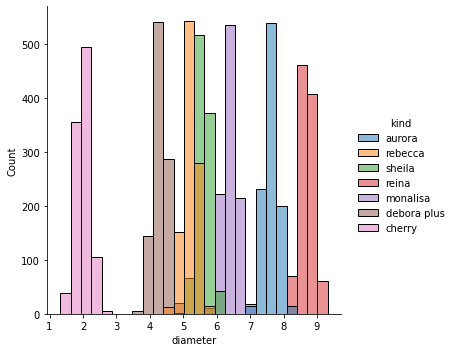

In [19]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.displot(df, x="diameter", hue="kind")
plt.show()

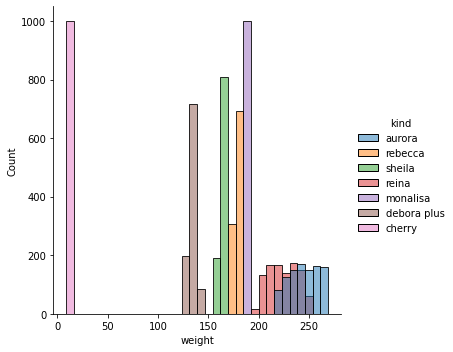

In [20]:
sns.displot(df, x="weight", hue="kind")
plt.show()

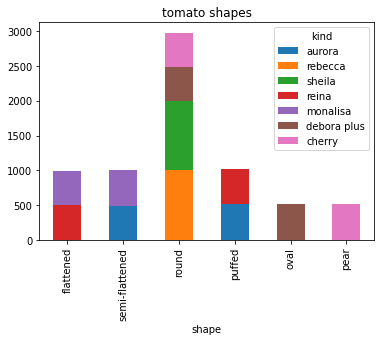

In [21]:
df.groupby(['shape', 'kind']).size().unstack().plot(kind='bar', stacked=True, title='tomato shapes')
plt.show()

---

# Prepare data to use for classifier

The xdf dataframe is the dataframe containing all the raw data (numbers). We will use this to fill the feature matrix $X$ and the vector $y$ with the labeled class. 


\begin{equation}
X = 
   \begin{bmatrix} \
    x_1^{(1)}  & x_2^{(1)} & x_3^{(1)}\\
    x_1^{(2)}  & x_2^{(2)} & x_3^{(2)}\\ 
    x_1^{(3)}  & x_2^{(3)} & x_3^{(3)} \\ 
    .. & .. & .. \\ 
    x_1^{(m)}  & x_2^{(m)} & x_3^{(m)} \\ 
   \end{bmatrix} 
   \
   %
   y = 
   \begin{bmatrix} \
   y^{(1)} \\
   y^{(2)} \\ 
   y^{(3)} \\ 
   .. \\ 
   y^{(m)} \\ 
   \end{bmatrix} 
  %
\end{equation}

The first column of xdf contains the class (to be put in the $y$ vector), the second, third and fourth column of xdf contain the features weight ($x_1$), diameter ($x_2$) and shape ($x_3$). The first sample is annotated as ($x_n^{(1)}$), so the first feature of the first sample is annotated as $x_1^{(1)}$

In [22]:
#split to features and labels
X = np.array(xdf[[1,2,3]]) #features
y = np.array(xdf[0]) #labels
print(X.shape)
print(y.shape)

(7000, 3)
(7000,)


A best practise is to split the data into a train and test set. The training samples are used to train the model, the test set is used to evaluate the model

In [23]:
#split in training set and test set
from sklearn.model_selection import train_test_split, ShuffleSplit

#split
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)

#cross validation
cv = ShuffleSplit(n_splits=10, test_size=test_size, random_state=0)

In [24]:
print(f'test sample: {len(y_test)}, train sample: {len(y_train)}')

test sample: 2100, train sample: 4900


---

# Build a decision tree classifier

We are now ready to build our classifier. To perform the classification, we first create a `DecisionTreeClassifier` object, in this example called `tree_clf`. Then we ask the object to execute the `fit`

In [25]:
from sklearn.tree import DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

We can visualize the tree with the graphviz module

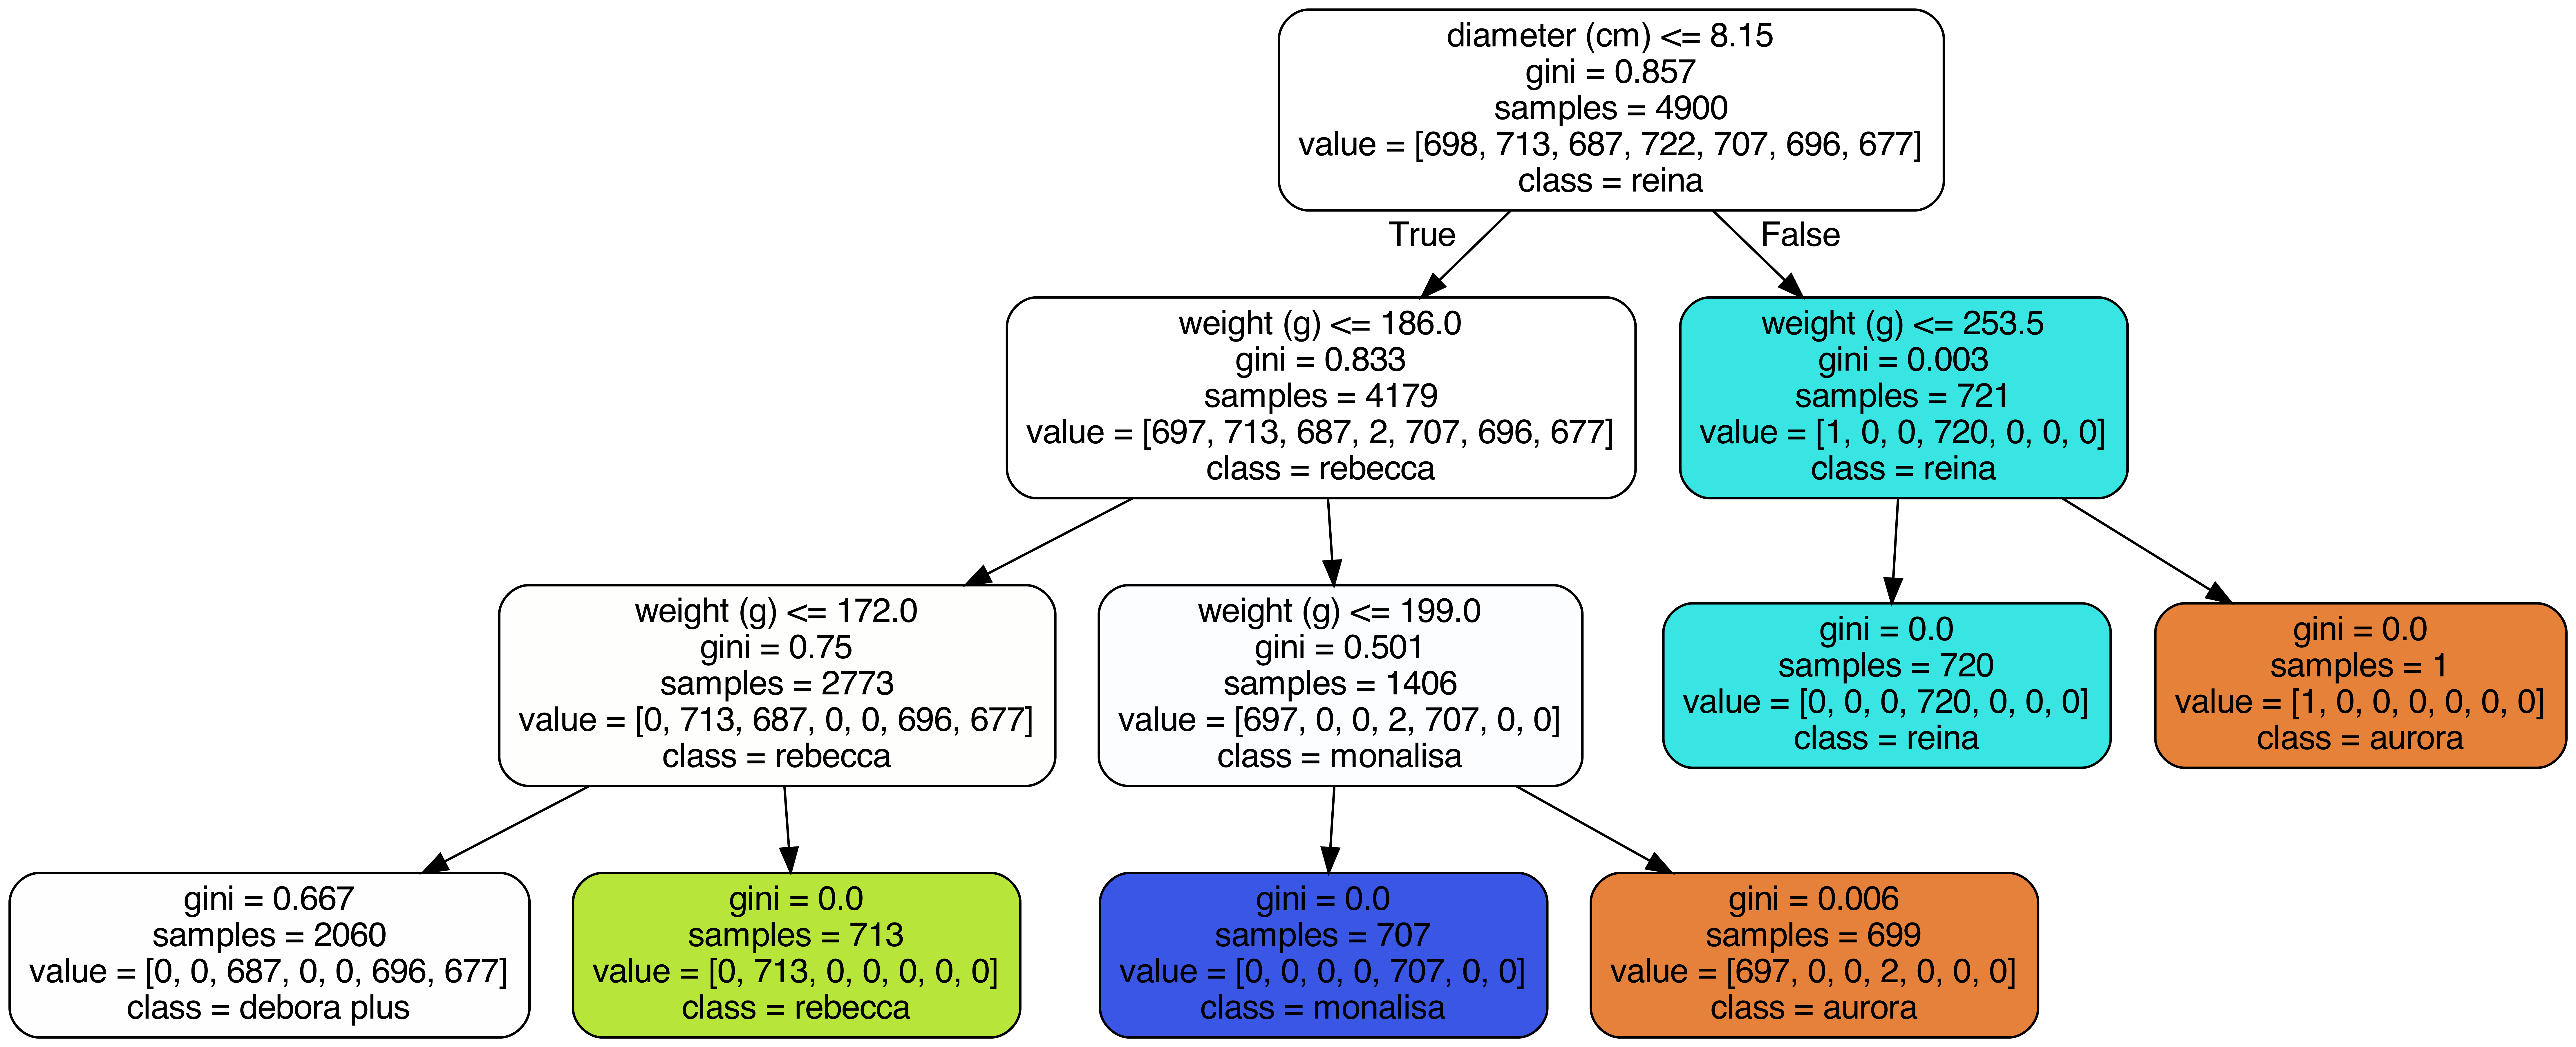

In [26]:
tomatoes = {'data' : X, 'target' : y, 
            'target_names' :['aurora', 'rebecca', 'sheila', 'reina', 'monalisa', 'debora plus', 'cherry'], 
            'feature_names' : ['weight (g)', 'diameter (cm)', 'shape (kind)']}

from sklearn.tree import export_graphviz

export_graphviz(
        tree_clf,
        out_file=("tree.dot"),
        feature_names=tomatoes['feature_names'],
        class_names=tomatoes['target_names'],
        rounded=True,
        filled=True
    )

call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])
Image(filename = 'tree.png')

We can read the picture of the decision tree as follows. Suppose you find an tomato and you want to classify it. You then start at the top of the **root node**, at **depth = 0**. The first question we need to ask ourselves is: Is the diameter smaller than 8.15 cm? If so, we descend down the *True* axis down to the next **child node**,at **depth = 1**. if there are not longer nodes to downsize we call it a **leaf node**. It has no children anymore. It is the maximum depth for this node. So we can see here what the predicted class is. 

In the picture we also see that a node attribute counts the number of samples. In our example, 100 samples have a diameter smaller than 3.115 cm and 600 samples have diameter to or greater than 3.115 cm. Of the 600 samples, 400 samples have a diameter smaller than 7.033 cm and 200 samples have a diameter greater than 7.032 cm.

The attribute `gini` says something about purity. A node is pure $ (gini = 0) $ if all training samples belong to the same class. For example, the `reina` node has a gini score of $$ 1 - (0/720) ^ 2 - (0/720) ^ 2 - (0/720) ^ 2 - (720/720) ^ 2 - (0/720) ^ 2 - (0/720) ^ 2 - (0/720) ^2 = 0 $$. 

The gini score is calculated by the formula

$$ G_i = 1 - \ sum_ {k = 1} ^ n P_i, k ^ 2 $$

the `aurora` node has a gini score of $$ 1 - (697/699) ^ 2 - (0/699) ^ 2 - (0/699) ^ 2 - (2/699) ^ 2 - (0/699) ^ 2 - (0/699) ^ 2 - (0/699) ^2 = 0.006 $$. 


---

# Use classifier

We can use the classifier by feeding the weight, diameter and shape into the classifier. It now uses the tree algorithm to determine the class. 

In [27]:
print('enter', tomatoes['feature_names'])

enter ['weight (g)', 'diameter (cm)', 'shape (kind)']


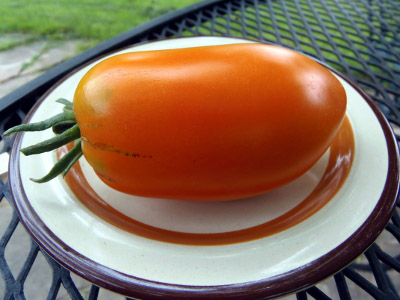

In [28]:
Image(filename = 'images/Reina.jpeg')

In [31]:
tomato[int(tree_clf.predict([[190, 6, 4]]))]

'monalisa'

---

# Evaluate classifier

In [23]:
y_pred = tree_clf.predict(X_test)

In [24]:
# function to evaluate
from sklearn.metrics import confusion_matrix

print('confusion matrix:')
print(confusion_matrix(y_test, y_pred))
print(f'\ntest  accuracy: {tree_clf.score(X_test, y_test)}')
print(f'train accuracy: {tree_clf.score(X_train, y_train)}')

confusion matrix:
[[300   0   0   2   0   0   0]
 [  0 287   0   0   0   0   0]
 [  0   0   0   0   0 313   0]
 [  0   0   0 278   0   0   0]
 [  0   0   0   0 293   0   0]
 [  0   0   0   0   0 304   0]
 [  0   0   0   0   0 323   0]]

test  accuracy: 0.6961904761904761
train accuracy: 0.7212244897959184


The accuracy is not that good. The accuracy is even on the training set low. The model fails to predict 'sheila' and 'cherry' and predicts too often 'debora plus'. As you can see in the tree picture, this is no leaf node. It is still a container class. Problably the classifier needs another configuration. For instance the possibility to use more depths. There is a danger though that you model too specific on the trainingset. Than it will *overfit* and perform not well on the test set in the end. Let us experiment on the depth

In [88]:
tree_clf = DecisionTreeClassifier(max_depth=4, random_state=42, class_weight = 'balanced')
tree_clf.fit(X_train, y_train)
y_pred = tree_clf.predict(X_test)
print('confusion matrix:')
print(confusion_matrix(y_test, y_pred))
print(f'\ntest  accuracy: {tree_clf.score(X_test, y_test)}')
print(f'train accuracy: {tree_clf.score(X_train, y_train)}')

export_graphviz(
        tree_clf,
        out_file=("tree.dot"),
        feature_names=tomatoes['feature_names'],
        class_names=tomatoes['target_names'],
        rounded=True,
        filled=True
    )

from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

from IPython.display import Image
Image(filename = 'tree.png')

confusion matrix:
[[302   0   0   0   0   0   0]
 [  0 287   0   0   0   0   0]
 [  0   0 313   0   0   0   0]
 [278   0   0   0   0   0   0]
 [  0   0   0   0 293   0   0]
 [  0   0   0   0   0 304   0]
 [  0   0   0   0   0   0 323]]

test  accuracy: 0.8676190476190476
train accuracy: 0.8526530612244898


In [89]:
tree_clf = DecisionTreeClassifier(max_depth=5, random_state=42, class_weight='balanced')
tree_clf.fit(X_train, y_train)
y_pred = tree_clf.predict(X_test)
print('confusion matrix:')
print(confusion_matrix(y_test, y_pred))
print(f'\ntest  accuracy: {tree_clf.score(X_test, y_test)}')
print(f'train accuracy: {tree_clf.score(X_train, y_train)}')

export_graphviz(
        tree_clf,
        out_file=("tree.dot"),
        feature_names=tomatoes['feature_names'],
        class_names=tomatoes['target_names'],
        rounded=True,
        filled=True
    )

call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])
Image(filename = 'tree.png')

confusion matrix:
[[299   0   0   3   0   0   0]
 [  0 287   0   0   0   0   0]
 [  0   0 313   0   0   0   0]
 [  1   0   0 277   0   0   0]
 [  0   0   0   0 293   0   0]
 [  0   0   0   0   0 304   0]
 [  0   0   0   0   0   0 323]]

test  accuracy: 0.9980952380952381
train accuracy: 0.9993877551020408
